In [75]:
#imports
import numpy as np
import networkx as nx
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
import torch
from torch_geometric.data import Data

In [76]:

NUM_FEATURES_PER_SERVICE = 4
service_names = [
            "recommendationservice", 
            "productcatalogservice", 
            
            "cartservice",
            "adservice",
            "paymentservice",
            "shippingservice",
            "currencyservice",
            "redis-cart",
            "checkoutservice",
            "frontend",
            "emailservice"
                    ]


# Define which services interact (caller → callee)
service_dependencies = {
    "frontend": ["recommendationservice", "productcatalogservice", "cartservice", "checkoutservice","currencyservice","shippingservice", "adservice"],
    "recommendationservice": ["productcatalogservice"],
    "cartservice": ["redis-cart"],
    "checkoutservice": ["cartservice", "paymentservice", "shippingservice","currencyservice","productcatalogservice",  "emailservice"],
    "paymentservice": [],
    "shippingservice": [],
    "emailservice": [],
    "adservice": [],
    "currencyservice": [],
    "productcatalogservice": [],
    "redis-cart": [],
}


traffic_metrics_list =[]
for source , destinations in service_dependencies.items():
    for destination in destinations :
        traffic_metrics_list.append(
            {
                "source" : source ,
                "destination" : destination ,
                "traffic" : random.uniform(0,100)
            }
        )
traffic_metrics_df =pd.DataFrame(traffic_metrics_list) 



def build_graph(metrics,traffic_metrics,num_features):
    # Step 1: build node feature map
    num_services = len(service_names)
    nodes = []
    for i in range(num_services):
        start = i * num_features
        features = metrics[start : start + num_features]
        nodes.append({
            # 'id': i,
            'name' : service_names[i],
            'cpu_usage' : features[0],
            'mem_usage' : features[1],
            'pod_count' : features[2],
            'desired_pod_count' : features[3],
        })



    # Step 2: build edges 
    edges = []
    for i in service_dependencies.keys():
        if service_dependencies[i] != []:
            for j in service_dependencies[i]:
                traffic = float(traffic_metrics[
                (traffic_metrics['source'] == i) & (traffic_metrics['destination'] == j)
            ]["traffic"])
                print(traffic)
                edges.append({'source': i, 'target': j, 'traffic': traffic})
    # Step 3: return graph as dict
    graph = {
        'nodes': nodes,
        'edges': edges
    }
    # print(graph)
    return graph
print(traffic_metrics_df)
graph = build_graph(tuple(\
        random.randint(1,100) for _ in range(len(service_names) * NUM_FEATURES_PER_SERVICE)),traffic_metrics_df,4)



                   source            destination    traffic
0                frontend  recommendationservice  77.765303
1                frontend  productcatalogservice  97.321205
2                frontend            cartservice  36.705045
3                frontend        checkoutservice  39.537839
4                frontend        currencyservice  16.361009
5                frontend        shippingservice  96.477600
6                frontend              adservice  88.688072
7   recommendationservice  productcatalogservice   1.239390
8             cartservice             redis-cart  57.318615
9         checkoutservice            cartservice  19.183032
10        checkoutservice         paymentservice  47.326185
11        checkoutservice        shippingservice  93.968163
12        checkoutservice        currencyservice   1.674587
13        checkoutservice  productcatalogservice   9.100631
14        checkoutservice           emailservice  63.091757
77.76530313049786
97.32120512545131
36.7

/tmp/ipykernel_19967/3505023938.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  traffic = float(traffic_metrics[


In [77]:
# def visualize_service_graph(graph_dict):
#     """
#     Visualizes a service graph from the given node/edge dictionary.
#     """
#     G = nx.DiGraph()
    
#     # Add nodes
#     for node in graph_dict['nodes']:
#         G.add_node(node['name'], label=node['name'])

#     # Add edges
#     for edge in graph_dict['edges']:
#         G.add_edge(edge['source'], edge['target'], weight=edge.get('value', 1))
    
#     # Create position layout
#     pos = nx.shell_layout(G)

#     # Draw nodes with labels
#     node_labels = nx.get_node_attributes(G, 'label')
#     nx.draw_networkx_nodes(G, pos, node_size=900, node_color='red')
#     nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

#     # Draw edges
#     edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
#     nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=edge_weights)

#     plt.title("Microservice Interaction Graph")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()


In [78]:


def visualize_service_graph(graph_dict, figsize=(12, 8), 
                          node_colors=None, edge_colors=None, show_weights=True,
                          random_colors=True, color_seed=None):
    """
    Visualizes a service graph with circular layout and styling.
    
    Args:
        graph_dict: Dictionary with 'nodes' and 'edges' keys
        figsize: Figure size tuple
        node_colors: Dict mapping node names to colors, or single color (overrides random_colors)
        edge_colors: Dict mapping edges to colors, or single color
        show_weights: Whether to show edge weights as labels
        random_colors: Whether to use random colors for nodes (default True)
        color_seed: Seed for random color generation (None for truly random)
    """
    
    
    
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for node in graph_dict['nodes']:
        node_type = node.get('type', 'service')
        G.add_node(node['name'], 
                  label=node['name'], 
                  type=node_type,
                  size=node.get('size', 1000))
    
    # Add edges with attributes
    for edge in graph_dict['edges']:
        weight = edge.get('traffic', 1)
        G.add_edge(edge['source'], edge['target'], 
                  weight=weight,
                  label=edge.get('label', ''))
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Choose layout algorithm

    pos = nx.circular_layout(G)

    # Determine node colors
    if node_colors is None and random_colors:
        # Generate random colors for each node
        if color_seed is not None:
            np.random.seed(color_seed)  # For reproducible colors
        
        node_colors = []
        for _ in G.nodes():
            # Generate bright, vibrant colors
            hue = np.random.random()
            saturation = 0.7 + np.random.random() * 0.3  # 70-100% saturation
            value = 0.8 + np.random.random() * 0.2       # 80-100% value
            
            # Convert HSV to RGB
            import colorsys
            r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
            hex_color = f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}'
            node_colors.append(hex_color)
    elif node_colors is None:
        # Default blue color if random_colors is False
        node_colors = ['#45B7D1'] * len(G.nodes())

    
    # Determine node sizes
    node_sizes = [G.nodes[node].get('size', 1000) for node in G.nodes()]
    
    # Draw nodes with enhanced styling
    nx.draw_networkx_nodes(G, pos, 
                          node_color=node_colors,
                          node_size=node_sizes,
                          alpha=0.9,
                          edgecolors='black',
                          linewidths=1.5)
    
    # Draw node labels with better positioning
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, 
                           labels=node_labels,
                           font_size=10,
                           font_weight='bold',
                           font_color='black')
    
    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [2 + (w / max_weight) * 3 for w in edge_weights]
    
    edge_color = edge_colors if edge_colors else '#666666'
    nx.draw_networkx_edges(G, pos,
                          edge_color=edge_color,
                          arrows=True,
                          arrowsize=20,
                          arrowstyle='-|>',
                          width=edge_widths,
                          alpha=0.7,
                          connectionstyle="arc3,rad=0.1")
    
    # Add edge labels if requested
    if show_weights:
        edge_labels = {}
        for u, v in G.edges():
            weight = G[u][v]['weight']
            label = G[u][v].get('label', '')
            if label:
                edge_labels[(u, v)] = f"{label}\n({weight})"
            else:
                edge_labels[(u, v)] = f"{weight:.2f} kbps"
        
        nx.draw_networkx_edge_labels(G, pos, edge_labels,
                                    font_size=8,
                                    bbox=dict(boxstyle="round,pad=0.3",
                                            facecolor='white',
                                            alpha=0.8))
    
    # Add title and styling
    plt.title("Microservice Interaction Graph", 
              fontsize=16, fontweight='bold', pad=20)
    
    # Remove type-based legend since we're using random colors
    # Legend is now optional and only shown if explicitly using typed nodes
    if node_colors is not None and isinstance(node_colors, dict):
        legend_elements = []
        for node_type, color in node_colors.items():
            legend_elements.append(mpatches.Patch(color=color, label=node_type.title()))
        plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G, pos


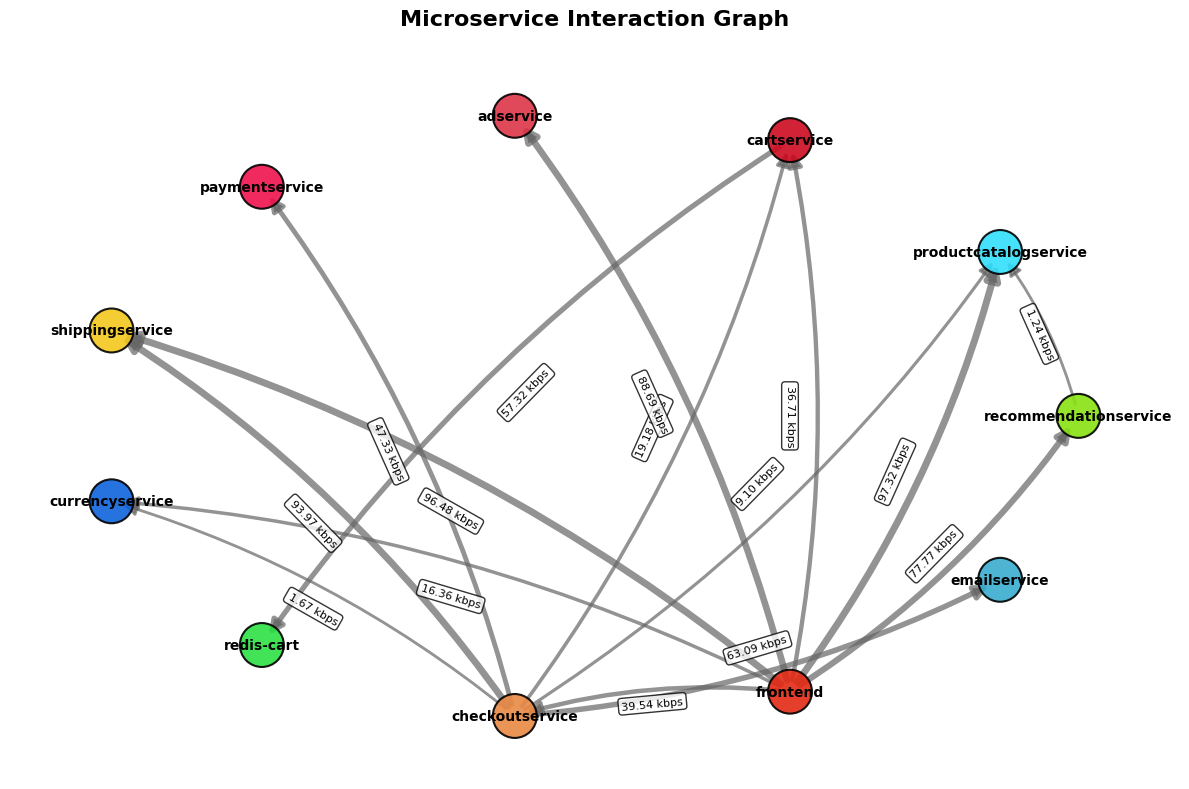

(<networkx.classes.digraph.DiGraph at 0x7c1d0cc2fe50>,
 {'recommendationservice': array([1.00000000e+00, 2.70930202e-09]),
  'productcatalogservice': array([0.84125352, 0.54064077]),
  'cartservice': array([0.41541508, 0.90963197]),
  'adservice': array([-0.14231483,  0.98982143]),
  'paymentservice': array([-0.65486067,  0.75574964]),
  'shippingservice': array([-0.95949297,  0.28173259]),
  'currencyservice': array([-0.95949297, -0.28173255]),
  'redis-cart': array([-0.65486073, -0.75574958]),
  'checkoutservice': array([-0.14231501, -0.98982143]),
  'frontend': array([ 0.41541511, -0.90963196]),
  'emailservice': array([ 0.84125346, -0.54064088])})

In [79]:
G = nx.Graph()
visualize_service_graph(graph)

In [80]:

node_list = graph["nodes"]
node_names = [node['name'] for node in node_list]
node_idx_map = {name: idx for idx, name in enumerate(node_names)}

x = torch.tensor([
    [node['cpu_usage'], node['mem_usage'], node['pod_count'], node['desired_pod_count']]
    for node in node_list
], dtype=torch.float)

edge_index = []
edge_attr = []

for edge in graph["edges"]:
    src = node_idx_map[edge["source"]]
    tgt = node_idx_map[edge["target"]]
    edge_index.append([src, tgt])
    edge_attr.append([edge["traffic"]])  # shape = [num_edges, 1]

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # shape: [2, num_edges]
edge_attr = torch.tensor(edge_attr, dtype=torch.float)



data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [81]:
data

Data(x=[11, 4], edge_index=[2, 15], edge_attr=[15, 1])